<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Wrangle-Data-and-Create-CSV" data-toc-modified-id="Wrangle-Data-and-Create-CSV-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Wrangle Data and Create CSV</a></span></li><li><span><a href="#Remove-Initial-Posts-and-Calculate-Frequency" data-toc-modified-id="Remove-Initial-Posts-and-Calculate-Frequency-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Remove Initial Posts and Calculate Frequency</a></span></li><li><span><a href="#Aggregate-Frequencies" data-toc-modified-id="Aggregate-Frequencies-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Aggregate Frequencies</a></span></li><li><span><a href="#Perform-T-Test-to-Determine-if-Greater-Conversation-Frequency-Among-Group-Members" data-toc-modified-id="Perform-T-Test-to-Determine-if-Greater-Conversation-Frequency-Among-Group-Members-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Perform T-Test to Determine if Greater Conversation Frequency Among Group Members</a></span></li><li><span><a href="#Wrangle-Data-For-Graph" data-toc-modified-id="Wrangle-Data-For-Graph-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Wrangle Data For Graph</a></span></li><li><span><a href="#Create-Graph" data-toc-modified-id="Create-Graph-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create Graph</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import itertools
from scipy.stats import ttest_ind
import networkx as nx
import matplotlib.pyplot as plt

## Wrangle Data and Create CSV

In [2]:
#read in files
willie_df = pd.read_csv('week3pt2_4pt2.csv')
ken_df = pd.read_csv('DS620_Discussion_Board_Data_Ken.csv')
ken_df.columns = ['Thread_Name','Initial_Post_or_Comment','Author','Response_To','Thread_Content']
willie_df = willie_df[['Thread_Name','Initial_Post_or_Comment','Author','Response_To','Thread_Content']]
jagdish_df = pd.read_csv('DS620_Discussion_Board_Data.csv')
thread_data_df = pd.concat([willie_df, ken_df, jagdish_df])

#Groups 
groups_list = [
    [1, 'Jithendra Seneviratne', 'Sheryl Piechocki'],
    [2, 'Jagdish Chhabria', 'Ken Popkin', 'Willie Smalls'],
    [3, 'Simon Ustoyev', 'Jack Russo', 'Elina Azrilyan', 'Murat Akyildirim'],
    [4, 'Mikhail Kollontai', 'Amber Ferger', 'Zachary Alexander', 'Subhalaxmi Rout'],
    [5, 'Habib Khan', 'Vijaya Cherukuri', 'Priya Shaji', 'Abdellah Ait Elmouden'],
    [6, 'Steven Ellingson'],
    [7, 'Wei Zhou', 'Mia Chen'],
    [8, 'Vanita Thompson', 'Mael Illien', 'Jeremy OBrien']
]

#clean up file
thread_data_df['Author'] = thread_data_df['Author'].replace(['Abdellah Ait Elmouden \n'],'Abdellah Ait Elmouden')
thread_data_df['Response_To'] = thread_data_df['Response_To'].replace(['Abdellah Ait Elmouden \n'],'Abdellah Ait Elmouden')
thread_data_df['Author'] = thread_data_df['Author'].replace(['Elina Azrilyan\xa0'],'Elina Azrilyan')

## review Jeremy O'Brien
thread_data_df['Response_To'] = thread_data_df['Response_To'].replace(["Jeremy O'Brien"], 'Jeremy OBrien')
thread_data_df['Author'] = thread_data_df['Author'].replace(["Jeremy O'Brien"], 'Jeremy OBrien')

## review Jit Seneviratne
thread_data_df['Response_To'] = thread_data_df['Response_To'].replace(['Jit Seneviratne'], 'Jithendra Seneviratne')
thread_data_df['Author'] = thread_data_df['Author'].replace(['Jit Seneviratne'], 'Jithendra Seneviratne')

## review Jagdish Chhabria
thread_data_df['Response_To'] = thread_data_df['Response_To'].replace(['Jagdish Chabria'], 'Jagdish Chhabria')
thread_data_df['Author'] = thread_data_df['Author'].replace(['Jagdish Chabria'], 'Jagdish Chhabria')

#remove spaces
thread_data_df['Response_To'] = thread_data_df['Response_To'].str.strip()
thread_data_df['Author'] = thread_data_df['Author'].str.strip()

#review distinct list of individuals
set(list(thread_data_df['Author']) + list(thread_data_df['Response_To']))

# #send dataframe to csv
thread_data_df.to_csv('final_thread_data_all.csv')
thread_data_df

FileNotFoundError: [Errno 2] File week3pt2_4pt2.csv does not exist: 'week3pt2_4pt2.csv'

## Remove Initial Posts and Calculate Frequency 

In [3]:
#Read File Back in 
thread_data_df = pd.read_csv('final_thread_data_all.csv')

#remove all intial posts
thread_data_df = thread_data_df[(thread_data_df['Initial_Post_or_Comment'] != 1)]

#calculate the frequency
thread_data_df = thread_data_df.groupby(['Author','Response_To']).size().reset_index(name='Freq')

#remove where the author is the same as the respond to, Two (2) records, probably missed in review
thread_data_df = thread_data_df.loc[thread_data_df['Author'] != thread_data_df['Response_To']]

thread_data_df

,Author,Response_To,Freq
0,Abdellah Ait Elmouden,Habib Khan,1
1,Abdellah Ait Elmouden,Jack Russo,1
2,Abdellah Ait Elmouden,Ken Popkin,1
3,Abdellah Ait Elmouden,Mael Illien,1
4,Abdellah Ait Elmouden,Mikhail Kollontai,1
...,...,...,...
135,Zachary Alexander,Jack Russo,1
136,Zachary Alexander,Priya Shaji,1
137,Zachary Alexander,Sheryl Piechocki,1
138,Zachary Alexander,Steven Ellingson,1


## Aggregate Frequencies

In [4]:
#create list of poster pairs and values
thread_data_list = thread_data_df.values.tolist()
thread_data_list

#Create a list of distinct class members
member_list = list(set(thread_data_df['Author'].values.tolist() + thread_data_df['Response_To'].values.tolist()))
member_combo_list = [list(combo) for combo in itertools.combinations(member_list, 2)]

#Create new list with row for count. 
member_combo_list2 = []
for pair in member_combo_list:
    pair.append(0)
    pair.append(0)
    member_combo_list2.append(pair)

    
#loop through pair list
for thread_pair_list in thread_data_list:

    for pair_id, pairs in enumerate(member_combo_list2):
        person_one = pairs[0]
        person_two = pairs[1]
        freq = pairs[2]
        
        #sum number of interactions
        if all(x in thread_pair_list for x in [person_one, person_two]):
            member_combo_list2[pair_id][2] = freq + thread_pair_list[2]
            

conversation_list = []
#remove all non conversation people
for i in member_combo_list2: 
    if i[2]>0:
        conversation_list.append(i)

conversation_list
# groups_list

for idx, pair in enumerate(conversation_list):
    person_one = pair[0]
    person_two = pair[1]
    
    for group in groups_list:
        if all(x in group for x in [person_one, person_two]):
            conversation_list[idx][3] = 1

conversation_df = pd.DataFrame(conversation_list)
conversation_df.columns = ['person_one', 'person_two', 'freq', 'group']
conversation_df

NameError: name 'groups_list' is not defined

## Perform T-Test to Determine if Greater Conversation Frequency Among Group Members 

T-Test indicates that we cannot conclude that there is not a greater frequency of communication among group members.

In [5]:
groups_df = conversation_df[(conversation_df.group==1)]['freq']
nongroups_df = conversation_df[(conversation_df.group==0)]['freq']
ttest_ind(groups_df, nongroups_df)

NameError: name 'conversation_df' is not defined

## Wrangle Data For Graph

In [6]:
#Bring in groups data fram 
groups_df = pd.DataFrame([
    ['group_1', 'Jithendra Seneviratne', 'blue'],
    ['group_1', 'Sheryl Piechocki', 'blue'],
    ['group_2', 'Jagdish Chhabria', 'red'],
    ['group_2', 'Ken Popkin', 'red'],
    ['group_2', 'Willie Smalls', 'red'],
    ['group_3', 'Elina Azrilyan', 'yellow'],
    ['group_3', 'Jack Russo', 'yellow'],
    ['group_3', 'Murat Akyildirim', 'yellow'],
    ['group_3', 'Simon Ustoyev', 'yellow'],
    ['group_4', 'Amber Ferger', 'orange'],
    ['group_4', 'Mikhail Kollontai', 'orange'],
    ['group_4', 'Subhalaxmi Rout', 'orange'],
    ['group_4', 'Zachary Alexander', 'orange'],
    ['group_5', 'Abdellah Ait Elmouden', 'green'],
    ['group_5', 'Habib Khan', 'green'],
    ['group_5', 'Priya Shaji', 'green'],
    ['group_5', 'Vijaya Cherukuri', 'green'],
    ['group_6', 'Steven Ellingson', 'cyan'],
    ['group_7', 'Mia Chen', 'purple'],
    ['group_7', 'Wei Zhou', 'purple'],
    ['group_8', 'Jeremy OBrien', 'magenta'],
    ['group_8', 'Mael Illien', 'magenta'],
    ['group_8', 'Vanita Thompson', 'magenta']
])
groups_df.columns = ['group', 'person_one', 'node_color']


#Add Groups Data
conversation_df1 = pd.merge(conversation_df, groups_df, on='person_one', how='inner')
groups_df.columns = ['group', 'person_two', 'node_color']
conversation_df1 = conversation_df1[['person_one', 'person_two', 'freq', 'group_y', 'node_color']]
conversation_df2 = pd.merge(conversation_df1, groups_df, on='person_two', how='inner')
conversation_df2 = conversation_df2[['person_one', 'person_two', 'freq', 'group_y', 'group', 'node_color_x']]
edges_df = conversation_df2
edges_df = edges_df.rename(columns={'person_one': 'source', 'person_two': 'target', 'freq': 'weight', 'group_y': 'source_group', 'group': 'target_group', 'node_color_x': 'node_color'})
edges_df

NameError: name 'conversation_df' is not defined

## Create Graph

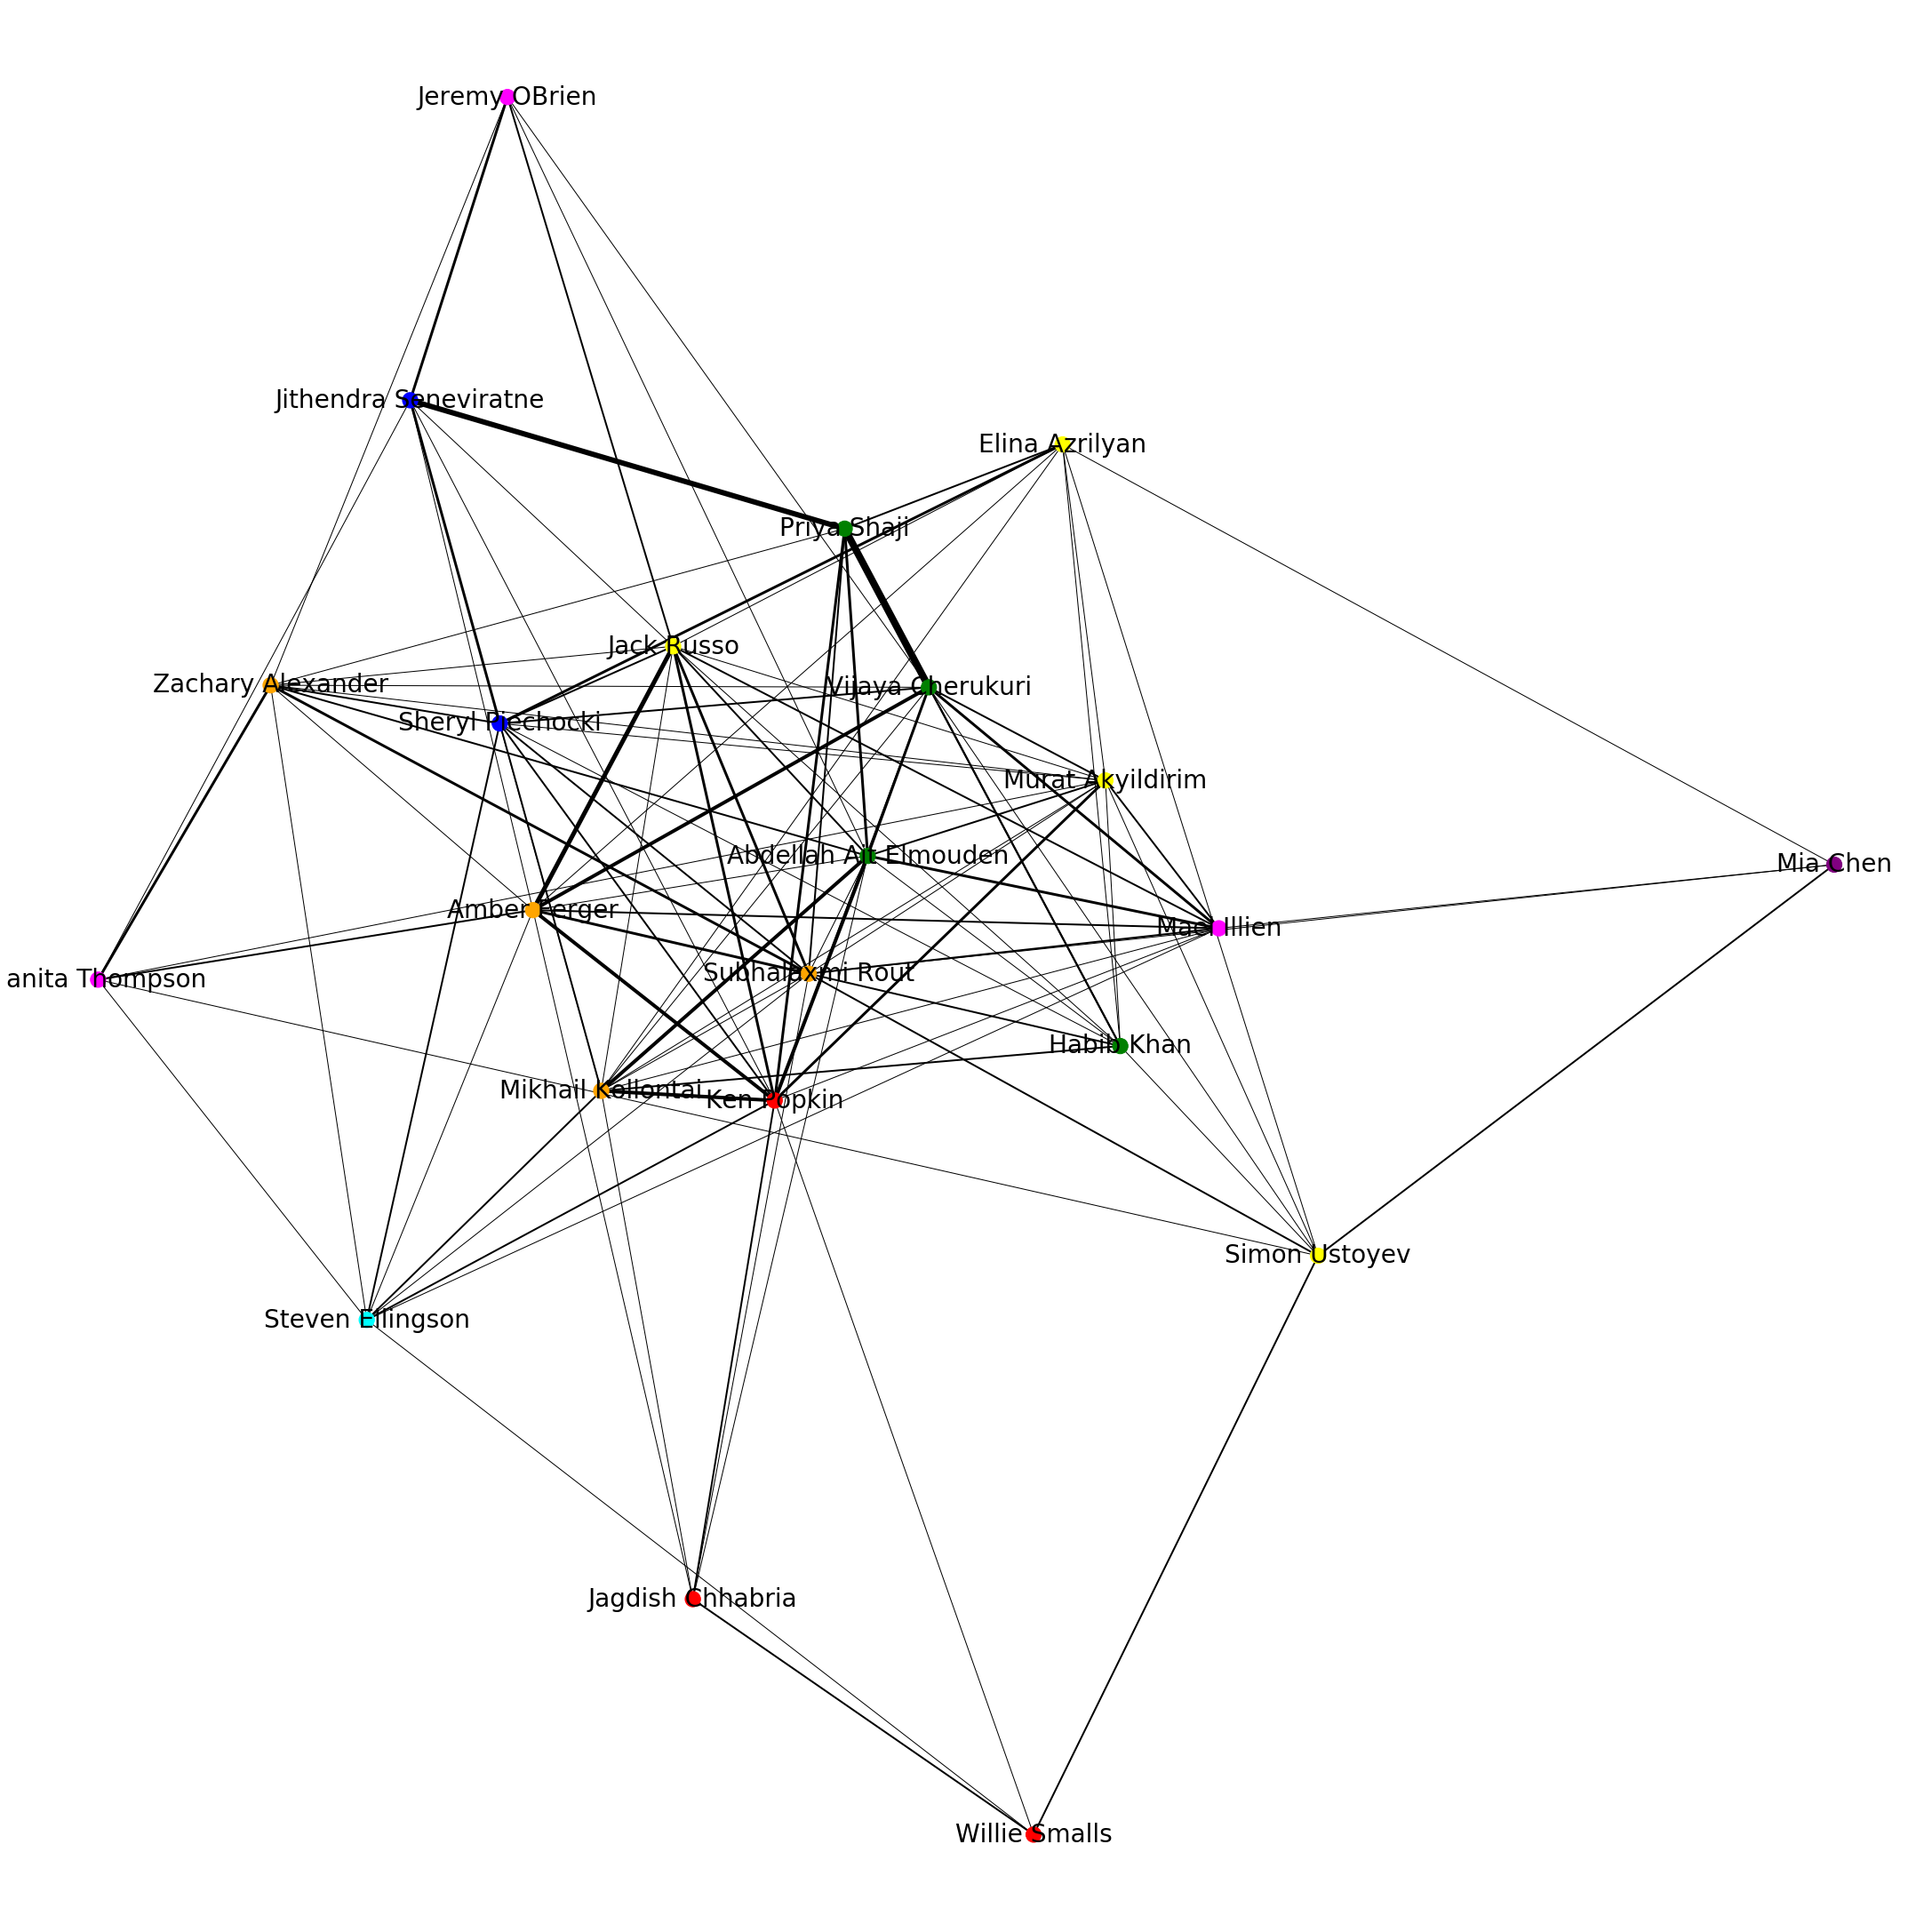

In [89]:
#create graph and add edges
groups_gph = nx.from_pandas_edgelist(edges_df, edge_attr=True)

#color code the nodes
color_map = []
for node in groups_gph:
    if node == 'Jithendra Seneviratne':
        color_map.append('blue')
    elif node == 'Sheryl Piechocki':
        color_map.append('blue')
    elif node == 'Jagdish Chhabria':
        color_map.append('red')
    elif node == 'Ken Popkin':
        color_map.append('red')
    elif node == 'Willie Smalls':
        color_map.append('red')
    elif node == 'Elina Azrilyan':
        color_map.append('yellow')
    elif node == 'Jack Russo':
        color_map.append('yellow')
    elif node == 'Murat Akyildirim':
        color_map.append('yellow')
    elif node == 'Simon Ustoyev':
        color_map.append('yellow')
    elif node == 'Amber Ferger':
        color_map.append('orange')
    elif node == 'Mikhail Kollontai':
        color_map.append('orange')
    elif node == 'Subhalaxmi Rout':
        color_map.append('orange')
    elif node == 'Zachary Alexander':
        color_map.append('orange')
    elif node == 'Abdellah Ait Elmouden':
        color_map.append('green')
    elif node == 'Habib Khan':
        color_map.append('green')
    elif node == 'Priya Shaji':
        color_map.append('green')
    elif node == 'Vijaya Cherukuri':
        color_map.append('green')
    elif node == 'Steven Ellingson':
        color_map.append('cyan')
    elif node == 'Mia Chen':
        color_map.append('purple')
    elif node == 'Wei Zhou':
        color_map.append('purple')
    elif node == 'Jeremy OBrien':
        color_map.append('magenta')
    elif node == 'Mael Illien':
        color_map.append('magenta')
    elif node == 'Vanita Thompson':
        color_map.append('magenta')

#Format Graph
plt.figure(figsize=(30,30)) 
#determine the weights
weights = [edata['weight'] for f, to, edata in groups_gph.edges(data=True)]
#draw map with weights, labels, and color map
nx.draw(groups_gph, with_labels=1, font_size=28, width = weights, node_color=color_map)